In [5]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go


In [6]:
covid_file = "./cov.csv"
influenza_file = "./influenza.csv"
flu_df = pd.read_csv(influenza_file)
cov_df = pd.read_csv(covid_file)


## Covid


In [7]:
cov_df

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0
...,...,...,...,...,...,...,...,...
202156,2022-04-30,ZW,Zimbabwe,AFRO,58,247842,0,5469
202157,2022-05-01,ZW,Zimbabwe,AFRO,0,247842,0,5469
202158,2022-05-02,ZW,Zimbabwe,AFRO,0,247842,0,5469
202159,2022-05-03,ZW,Zimbabwe,AFRO,0,247842,0,5469


In [8]:
# prepare data for analisis
def get_singe_country(country_name):
    country_cov = cov_df[cov_df["Country"] == country_name]
    columns = ["Date_reported","New_cases", "Cumulative_cases", "New_deaths", "Cumulative_deaths"]
    country_cov = country_cov[columns].reset_index().drop("index", axis=1)
    country_cov["Date_reported"] = pd.to_datetime(country_cov["Date_reported"])
    start_date = datetime.datetime(2020,1,1)
    stop_date = datetime.datetime(2020,12,31)
    mask = (country_cov["Date_reported"] >= start_date) & (country_cov["Date_reported"] <= stop_date)
    country_cov = country_cov[mask]
    country_cov = country_cov.set_index(country_cov["Date_reported"]).drop("Date_reported", axis=1)
    pol_cov_month = country_cov.groupby(country_cov.index.to_period('m')).sum().drop(["Cumulative_cases", "Cumulative_deaths"], axis=1) # get month summary ammount
    return pol_cov_month


#### Get df with all countries with sumary cases and deaths

In [41]:
df_sumary_death_and_cases = pd.DataFrame(columns=["country", "cases_sumary", "deaths_sumary"])
all_countries = cov_df["Country"].unique()
all_countries_data = {country: get_singe_country(country) for country in all_countries}
for country, _df in all_countries_data.items():
    tmp_dict = pd.DataFrame({"country":country, "cases_sumary": [_df["New_cases"].sum()], "deaths_sumary":[_df["New_deaths"].sum()]})
    df_sumary_death_and_cases = pd.concat([df_sumary_death_and_cases, tmp_dict], ignore_index=True)
df_sumary_death_and_cases

,country,cases_sumary,deaths_sumary
0,Afghanistan,52330,2189
1,Albania,57727,1174
2,Algeria,99311,2751
3,American Samoa,0,0
4,Andorra,7983,84
...,...,...,...
232,Viet Nam,1456,35
233,Wallis and Futuna,4,0
234,Yemen,2101,611
235,Zambia,20462,386


In [23]:
df_sumary_death_and_cases.describe()

,country,cases_sumary,deaths_sumary
count,237,237,237
unique,237,221,178
top,Afghanistan,0,0
freq,1,14,38


In [45]:
max_deaths = df_sumary_death_and_cases.query('cases_sumary == cases_sumary.max()')
print(max_deaths)
print()
min_deaths = df_sumary_death_and_cases.query('cases_sumary == cases_sumary.min()')
print(min_deaths)


                      country cases_sumary deaths_sumary
226  United States of America     19579818        351845

                                   country cases_sumary deaths_sumary
3                           American Samoa            0             0
46                            Cook Islands            0             0
54   Democratic People's Republic of Korea            0             0
110                               Kiribati            0             0
135       Micronesia (Federated States of)            0             0
144                                  Nauru            0             0
152                                   Niue            0             0
160                                  Palau            0             0
166                       Pitcairn Islands            0             0
179                           Saint Helena            0             0
214                                Tokelau            0             0
215                                  Tonga   

<Axes: ylabel='Frequency'>

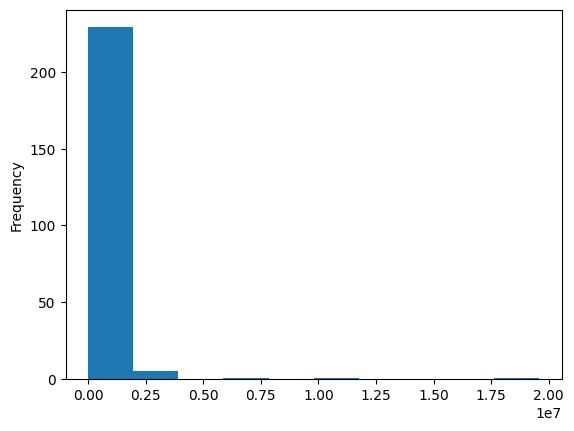

In [46]:
df_sumary_death_and_cases["cases_sumary"].plot(kind="hist")

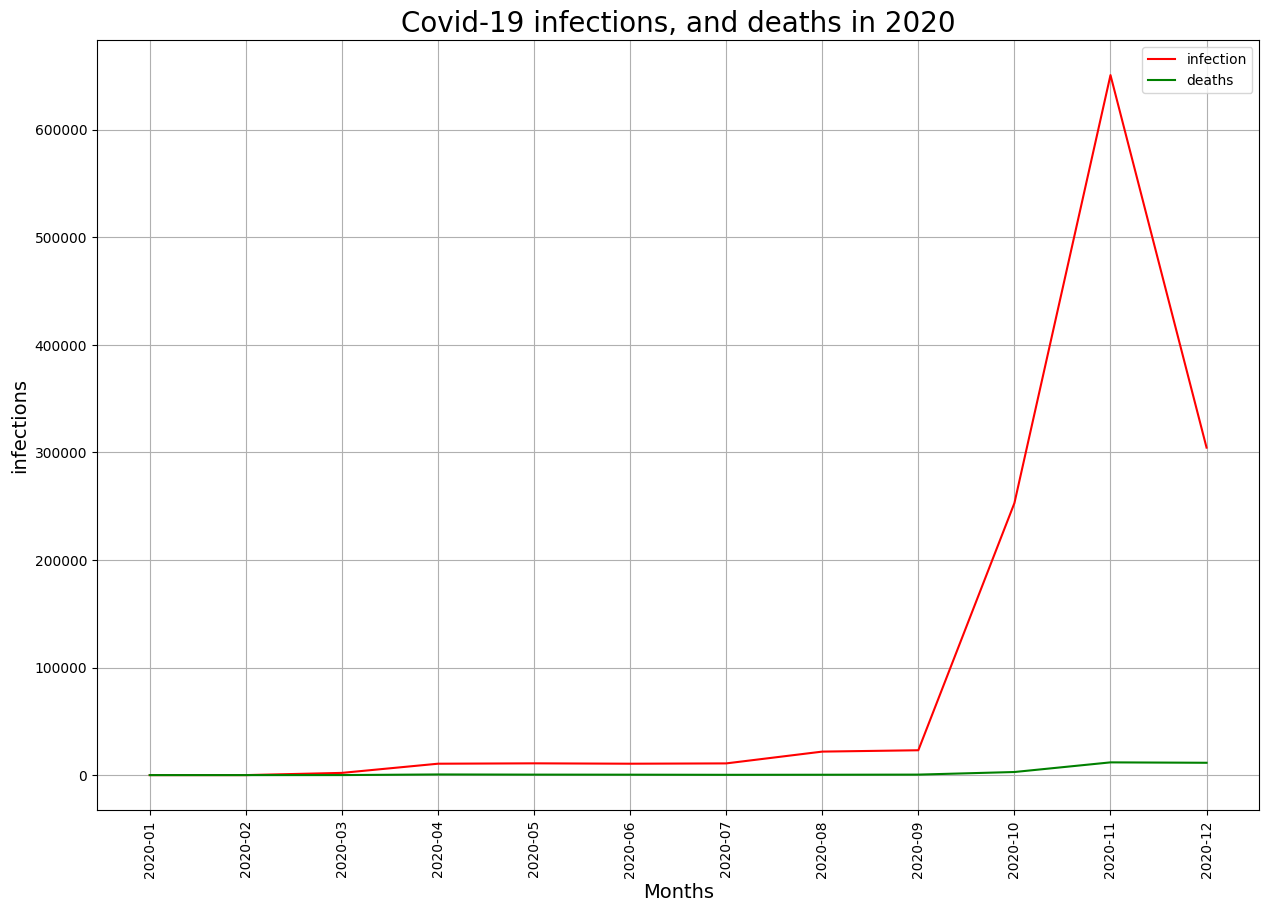

In [19]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
plt.xlabel("Months", fontdict={'fontsize': 14})
plt.ylabel("infections", fontdict={'fontsize': 14})
plt.grid()
plt.title("Covid-19 infections, and deaths in 2020", fontdict={'fontsize':20})
plt.plot(pol_cov_month["Date_reported"], pol_cov_month["New_cases"], color='r')
plt.plot(pol_cov_month["Date_reported"], pol_cov_month["New_deaths"], color='g')
plt.legend(["infection", "deaths"])


In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pol_cov_month["Date_reported"], y=pol_cov_month["New_cases"], name="infected", mode="lines+markers+text", text=pol_cov_month["New_cases"], textposition="top left"))
fig.add_trace(go.Scatter(x=pol_cov_month["Date_reported"], y=pol_cov_month["New_deaths"], name="deaths", mode="lines+markers+text", text=pol_cov_month["New_deaths"], textposition="bottom center"))
fig.update_layout(title="Covid-19 infections, and deaths 2020 in POLAND",
                    height=800,
                    xaxis=dict(
                        tickmode = 'array',
                        tickvals = pol_cov_month["Date_reported"],
                        tickangle=300
                    ),
                    yaxis_title="People",
                    )
fig.update_traces(textposition="top right")
fig.show()

## influenza

In [21]:
influenza_file = "./influenza.csv"
flu_df = pd.read_csv(influenza_file)

In [22]:
def remove_first_number(s):
    patt = "[0-9]*-"
    return re.sub(patt, '',s, 1)

flu_df["Unnamed: 0"] = pd.to_datetime(flu_df["Unnamed: 0"].apply(remove_first_number))
flu_df
flu_df = flu_df.set_index(flu_df["Unnamed: 0"])
flu_month = flu_df.groupby(flu_df.index.to_period('m')).sum().reset_index()
flu_month.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
flu_month["Date"] = flu_month["Date"].astype(str)
flu_month # make pickle


ValueError: time data "15-1-2020" doesn't match format "%m-%d-%Y", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=flu_month["Date"], y=flu_month["Confirmed"], name="infected", mode="lines+markers+text", text=flu_month["Confirmed"], textposition="top left"))
fig.add_trace(go.Scatter(x=flu_month["Date"], y=flu_month["Deaths"], name="deaths", mode="lines+markers+text", text=flu_month["Deaths"], textposition="bottom left"))
fig.update_traces(textposition="top center")
fig.update_layout(title="Influenza infections, and deaths 2020 in POLAND",
                    height=800,
                    xaxis=dict(
                        tickmode = 'array',
                        tickvals = flu_month["Date"],
                        tickangle=300
                    ),
                    yaxis_title="People",
                    )


fig.show()

NameError: name 'flu_month' is not defined